In [36]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.processors.altimeter import Altimeter
from mmwave_radar_processing.processors.velocity_estimator import VelocityEstimator
from mmwave_radar_processing.processors.range_resp import RangeProcessor
from mmwave_radar_processing.plotting.plotter_odometry_data import PlotterOdometryData
from mmwave_radar_processing.plotting.movies_odometry import MovieGeneratorOdometry

In [37]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"6843_RadVel_ods_10Hz.cfg")
cfg_manager.load_cfg(cfg_path,array_geometry="ods")
cfg_manager.compute_radar_perforance(profile_idx=0)
print(f"Radar Range Resolution: {cfg_manager.range_res_m:.4f} m")

dataset_name = "CPSL_RadVel_ods_10Hz_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

Radar Range Resolution: 0.0625 m
/data/RadVel/CPSL_RadVel_ods_10Hz_1
found 452 radar samples
did not find lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 452 vehicle velocity samples
found 452 vehicle odometry samples


In [38]:
plotter = PlotterOdometryData(config_manager=cfg_manager)
plotter.min_threshold_dB = 30

altimeter = Altimeter(
    config_manager=cfg_manager,
    min_altitude_m=15.0e-2,
    zoom_search_region_m=20.0e-2,
    altitude_search_limit_m=20e-2,
    range_bias=-0.13
)

velocity_estimator = VelocityEstimator(
    config_manager=cfg_manager,
    lower_range_bound=0.1,
    upper_range_bound=0.5,
    precise_vel_bound=0.20,
    peak_threshold_dB=30.0,
    min_velocity_mag=0.00,
    max_residual=100
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)


In [39]:
#initialize the movie generator
movie_generator = MovieGeneratorOdometry(
    cpsl_dataset=dataset,
    plotter=plotter,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_ods_10Hz_1


100%|██████████| 7/7 [00:00<00:00, 52.52it/s]


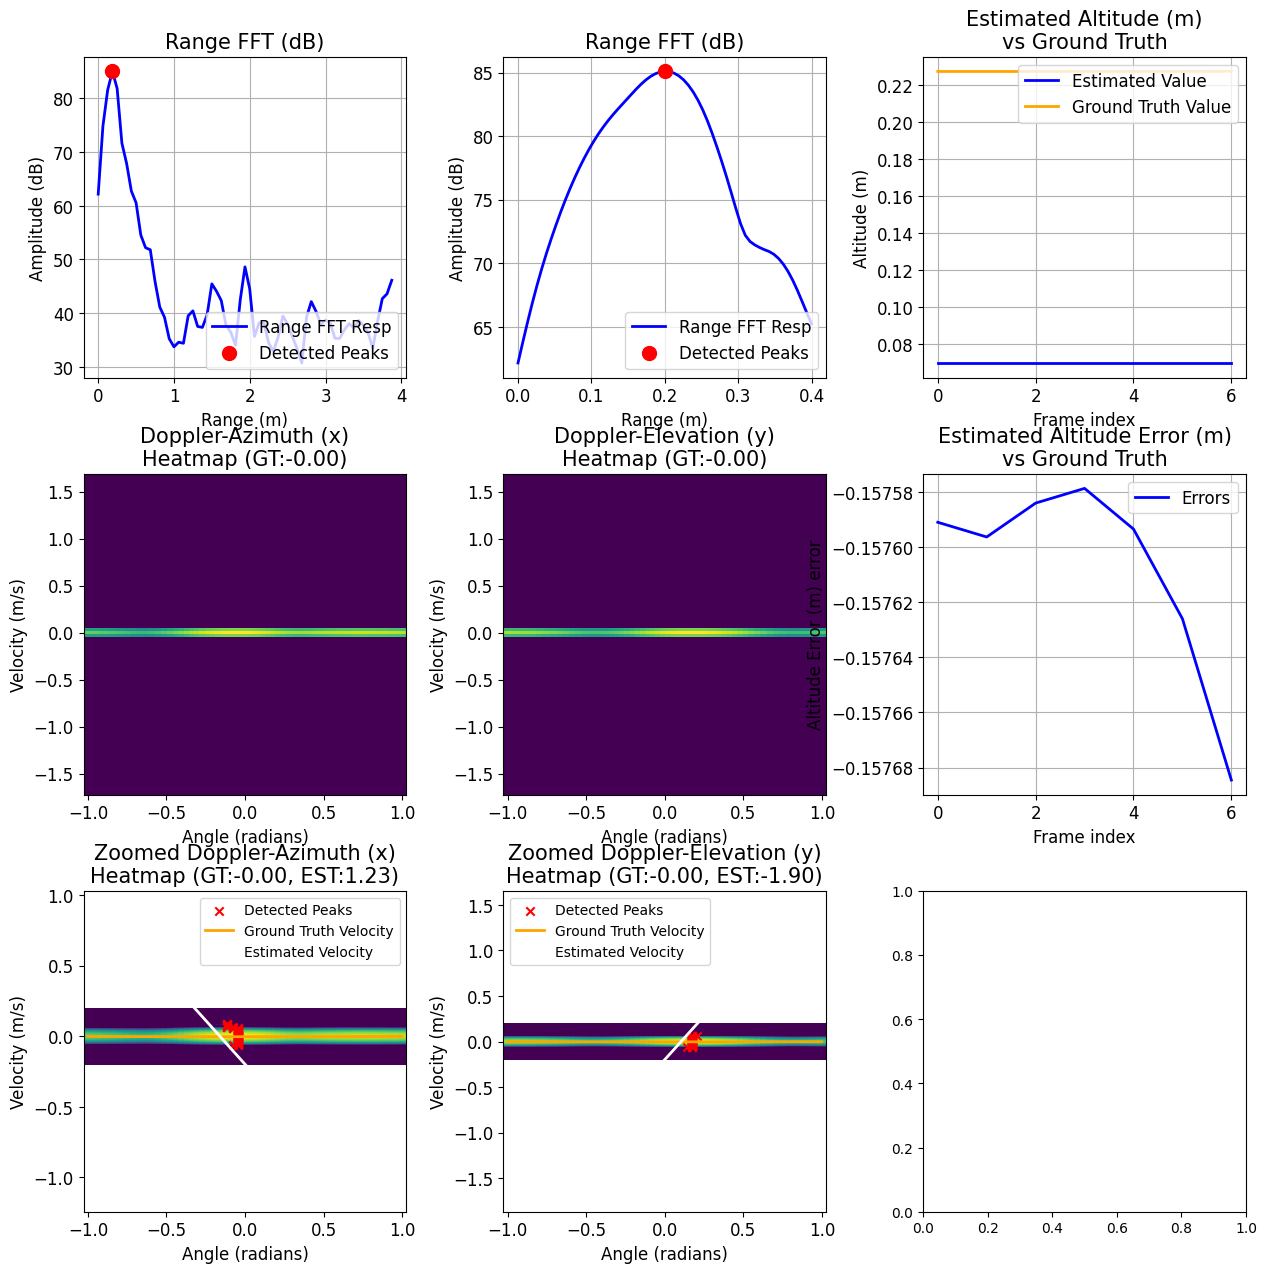

In [40]:
#for getting access to the adc cube
idx=7#310#dataset.num_frames
altimeter.reset()
velocity_estimator.reset()
#compute responses over a series of frames
#get the ADC cube

for i in tqdm(range(idx)):
    adc_cube = dataset.get_radar_data(i)
    adc_cube = virtual_array_reformatter.process(adc_cube)

    #estimate the altitude
    est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)
    
    #save the altitude history
    vehicle_odom = dataset.get_vehicle_odom_data(idx=i)
    gt_altitude = np.average(vehicle_odom[:, 3])
    altimeter.update_history(
        estimated=np.array([est_altitude]),
        ground_truth=np.array([gt_altitude])
    )


    #estimate the velocity
    vel_est = velocity_estimator.process(
        adc_cube=adc_cube,
        altitude=est_altitude,
        enable_precise_responses=True)
    
    #save the gt velocity history
    vehicle_vel_x = np.average(vehicle_odom[:,8])
    vehicle_vel_y = np.average(vehicle_odom[:,9])
    vehicle_vel_z = np.average(vehicle_odom[:,10])
    velocity_estimator.update_history(
        ground_truth=np.array([vehicle_vel_x,vehicle_vel_y,vehicle_vel_z]),
        estimated=vel_est
    )

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(3,3, figsize=(15,15))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    altimeter=altimeter,
    velocity_estimator=velocity_estimator,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    axs=axs,
    show=True
)

In [41]:
#evaluating the quality of an estimate
adc_cube = dataset.get_radar_data(i)
adc_cube = virtual_array_reformatter.process(adc_cube)

#estimate the altitude
est_altitude = altimeter.process(adc_cube=adc_cube, precise_est_enabled=True)

#save the altitude history
vehicle_odom = dataset.get_vehicle_odom_data(idx=i)
gt_altitude = np.average(vehicle_odom[:, 3])
altimeter.update_history(
    estimated=np.array([est_altitude]),
    ground_truth=np.array([gt_altitude])
)


#estimate the velocity
vel_est = velocity_estimator.process(
    adc_cube=adc_cube,
    altitude=est_altitude,
    enable_precise_responses=True)

#save the gt velocity history
vehicle_vel_x = np.average(vehicle_odom[:,8])
vehicle_vel_y = np.average(vehicle_odom[:,9])
vehicle_vel_z = np.average(vehicle_odom[:,10])

Estimated Velocity: [0.19011074 2.38783936], Residual: [0.08068079]


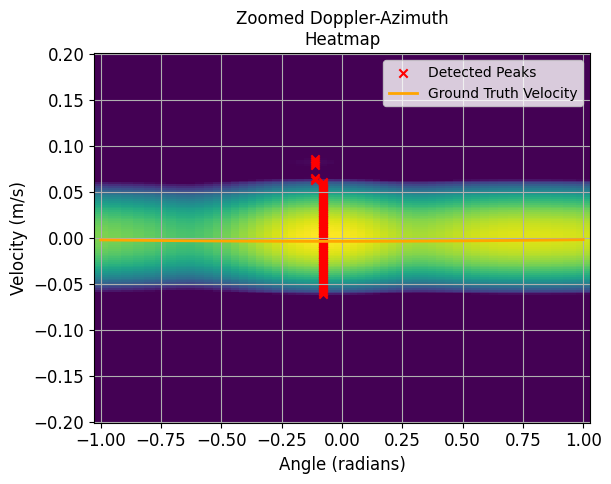

In [44]:
#compute the azimuth response
velocity_estimator.compute_azimuth_response(
    adc_cube=adc_cube,
    altitude=est_altitude,
    use_precise_fft=True
)

#estimate the velocities
v_ego,rss = velocity_estimator.lsq_fit_ego_velocity(
    peaks=velocity_estimator.azimuth_peaks,
)

print(f"Estimated Velocity: {v_ego}, Residual: {rss}")

#plot the doppler azimuth response
fig,ax = plt.subplots()
plotter.plot_zoomed_doppler_az_resp(
    resp = velocity_estimator.precise_azimuth_response_mag,
    doppler_azimuth_processor=velocity_estimator,
    peaks=velocity_estimator.azimuth_peaks,
    vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="azimuth"),
    # vd_estimated=velocity_estimator.get_estimated_velocity_measurement_predictions(direction="azimuth"),
    ax=ax,
    convert_to_dB=True,
    show=False,
)
ax.set_title("Zoomed Doppler-Azimuth\nHeatmap")
plt.grid()
plt.show()

Estimated Velocity: [ 0.34190856 -1.92812336], Residual: [0.08022222]


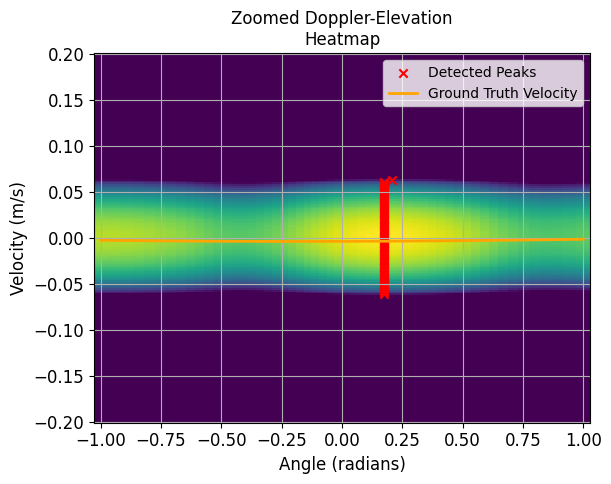

In [46]:
#compute the elevation response
velocity_estimator.compute_elevation_response(
    adc_cube=adc_cube,
    altitude=est_altitude,
    use_precise_fft=True
)

#estimate the velocities
v_ego,rss = velocity_estimator.lsq_fit_ego_velocity(
    peaks=velocity_estimator.elevation_peaks,
)

print(f"Estimated Velocity: {v_ego}, Residual: {rss}")

#plot the doppler elevation response
fig,ax = plt.subplots()
plotter.plot_zoomed_doppler_az_resp(
    resp = velocity_estimator.precise_elevation_response_mag,
    doppler_azimuth_processor=velocity_estimator,
    peaks=velocity_estimator.elevation_peaks,
    vd_ground_truth=velocity_estimator.get_gt_velocity_measurement_predictions(direction="elevation"),
    # vd_estimated=velocity_estimator.get_estimated_velocity_measurement_predictions(direction="elevation"),
    ax=ax,
    convert_to_dB=True,
    show=False,
)
ax.set_title("Zoomed Doppler-Elevation\nHeatmap")
plt.grid()
plt.show()

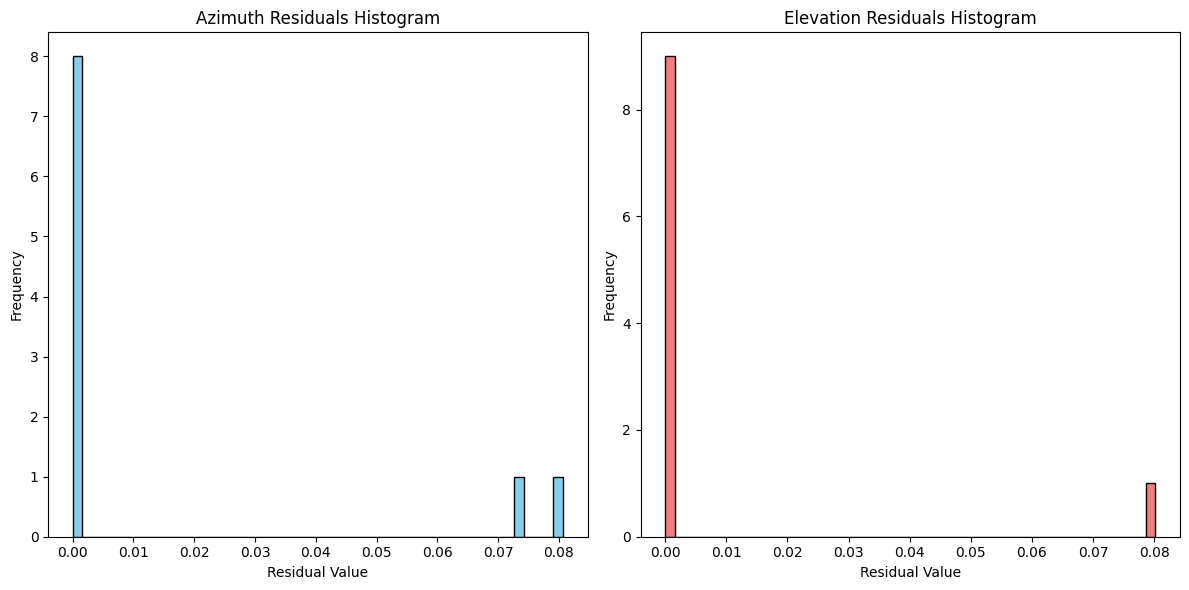

In [28]:
residuals = np.stack(velocity_estimator.history_residuals,axis=0)
az_residuals = residuals[:,0]
el_residuals = residuals[:,1]   

az_residuals = az_residuals[az_residuals >= 0.00]
el_residuals = el_residuals[el_residuals >= 0.00]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(az_residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('Azimuth Residuals Histogram')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(el_residuals, bins=50, color='lightcoral', edgecolor='black')
plt.title('Elevation Residuals Histogram')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

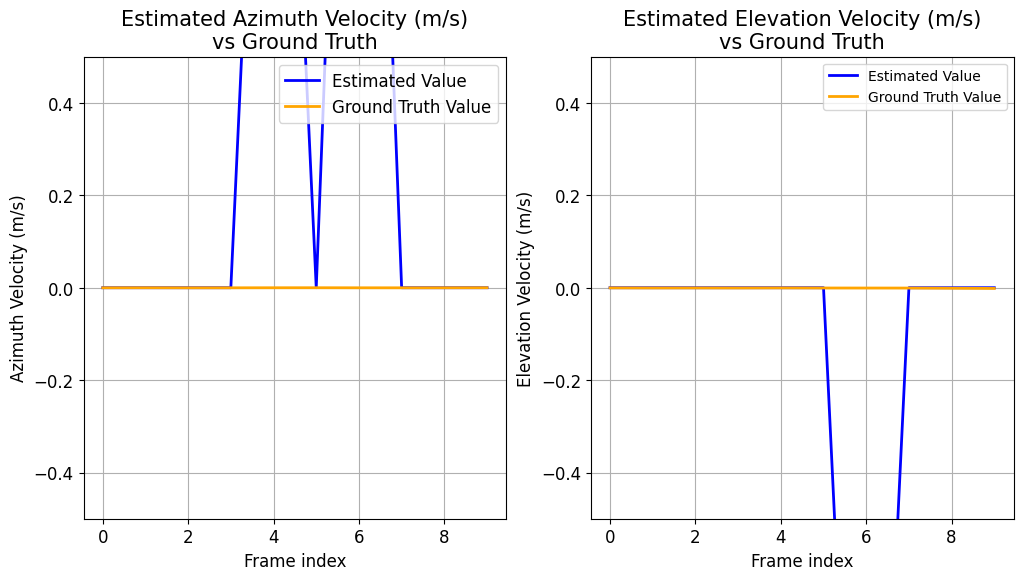

In [29]:
#comparing azimuth performance
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)
residuals = np.stack(velocity_estimator.history_residuals,axis=0)

fig,ax = plt.subplots(1,2,figsize=(12,6))

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,0],
    ground_truth=vel_gt[:,1],
    value_label="Azimuth Velocity (m/s)",
    ax=ax[0],
    show=False
)
ax[0].set_ylim([-0.5,0.5])

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[:,1],
    ground_truth=vel_gt[:,0],
    value_label="Elevation Velocity (m/s)",
    ax=ax[1],
    show=False
)
ax[1].set_ylim([-0.5,0.5])

# ax.plot(residuals[:,1],label="Elevation Residuals")
plt.legend()
plt.show()

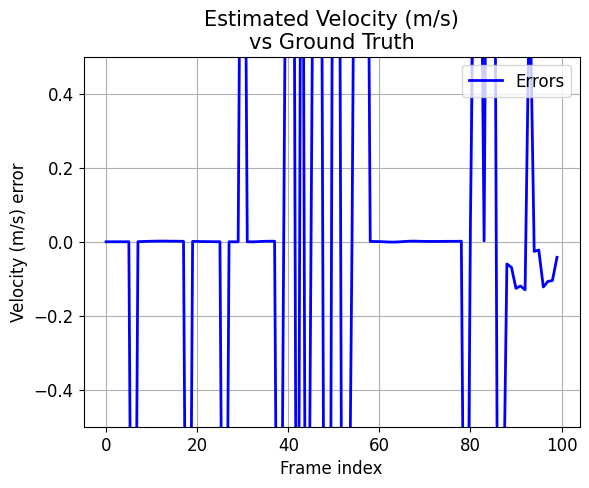

In [11]:
#comparing azimuth performance
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)



fig,ax = plt.subplots()

# ax.plot(residuals[:,0],label="Azimuth Residuals",color="red")
plt.ylim([-0.5,0.5])
plt.grid()
plotter.plot_estimated_vs_ground_truth_error(
    estimated=vel_est[:,1],
    ground_truth=vel_gt[:,0],
    value_label="Velocity (m/s)",
    ax=ax,
    show=True
)

Error Metric    Value
  Mean Error 0.513993
Median Error 0.002085
  RMSE Error 0.952044




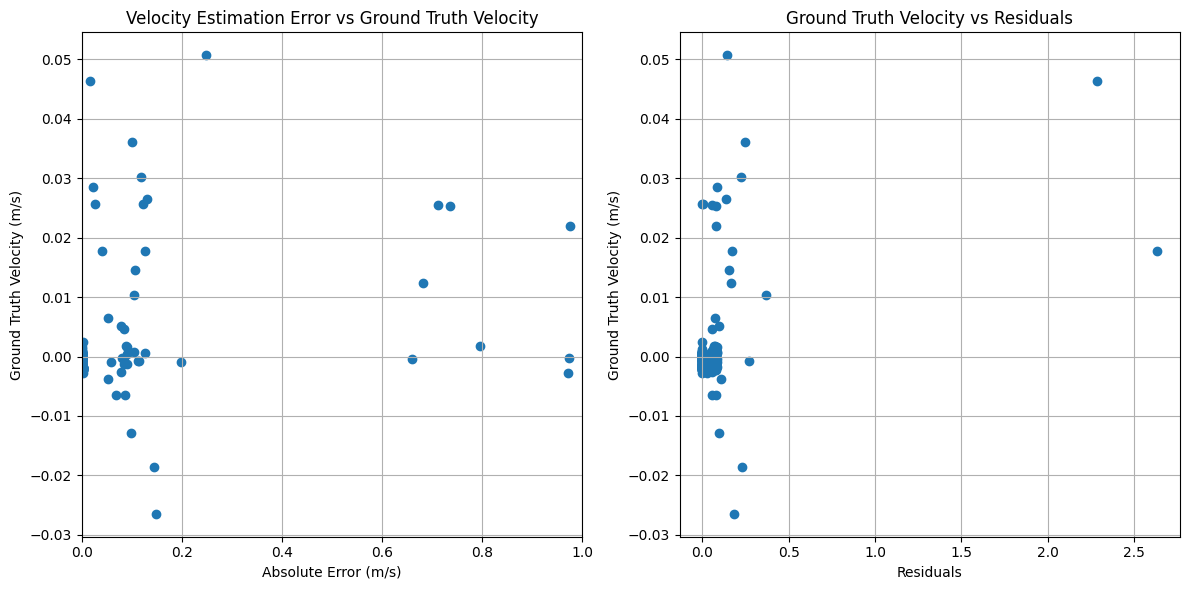

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_vel_est_az = vel_est[:,0]
x_vel_gt_az = vel_gt[:,1]
x_vel_est_el = vel_est[:,1]
x_vel_gt_el = vel_gt[:,0]

errors_az = np.abs(x_vel_est_az - x_vel_gt_az)
errors_el = np.abs(x_vel_est_el - x_vel_gt_el)

residuals = np.stack(velocity_estimator.history_residuals,axis=0)
az_residuals = residuals[:,0]
el_residuals = residuals[:,1]

errors = np.concatenate([errors_az, errors_el])
vel_gt = np.concatenate([x_vel_gt_az, x_vel_gt_el])
residuals = np.concatenate([az_residuals, el_residuals])

# errors = errors_az
# x_vel_gt = x_vel_gt_az

# Calculate mean, median, and RMSE
mean_error = np.mean(errors)
median_error = np.median(errors)
rmse_error = np.sqrt(np.mean(errors ** 2))

# Create a Pandas DataFrame for the table
table_data = {
    "Error Metric": ["Mean Error", "Median Error", "RMSE Error"],
    "Value": [mean_error, median_error, rmse_error]
}
table = pd.DataFrame(table_data)

print(table.to_string(index=False))
print("\n")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of errors vs ground truth
axs[0].scatter(errors, vel_gt)
axs[0].set_xlabel("Absolute Error (m/s)")
axs[0].set_ylabel("Ground Truth Velocity (m/s)")
axs[0].set_title("Velocity Estimation Error vs Ground Truth Velocity")
axs[0].grid(True)
axs[0].set_xlim(0,1)

# Scatter plot of ground truth vs residuals
axs[1].scatter(residuals, vel_gt)
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Ground Truth Velocity (m/s)")
axs[1].set_title("Ground Truth Velocity vs Residuals")
axs[1].grid(True)

plt.tight_layout()
plt.show()


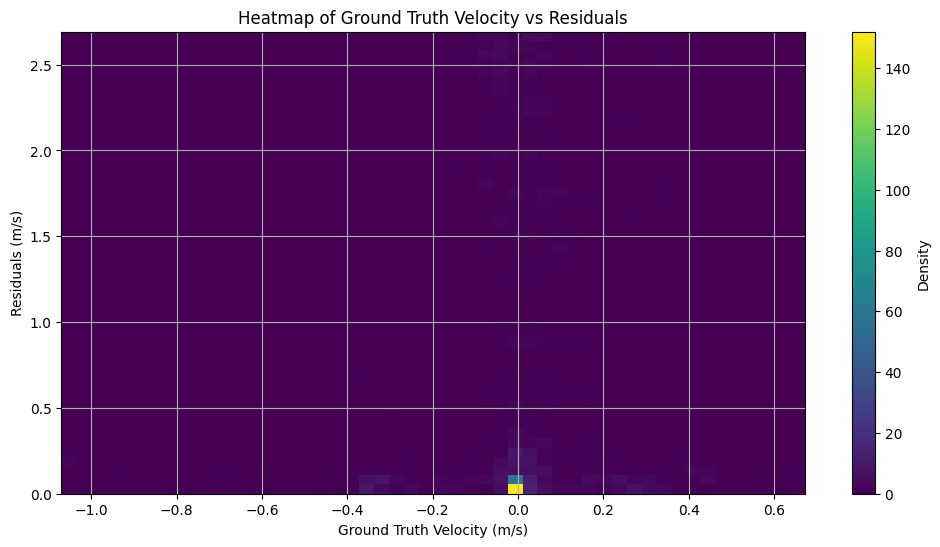

In [77]:
plt.figure(figsize=(12, 6))
plt.hist2d(vel_gt, residuals, bins=(50, 50), cmap="viridis")
plt.colorbar(label="Density")
plt.title("Heatmap of Ground Truth Velocity vs Residuals")
plt.xlabel("Ground Truth Velocity (m/s)")
plt.ylabel("Residuals (m/s)")
plt.grid(True)
plt.show()

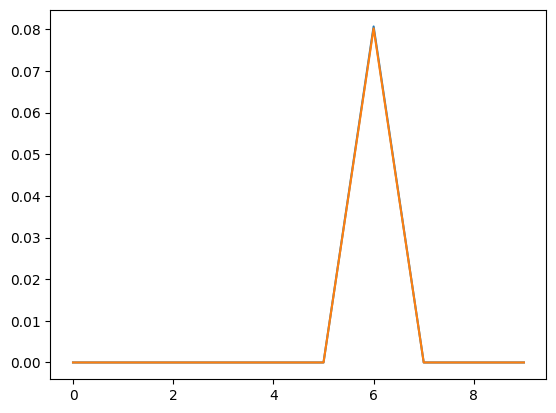

In [94]:
residuals = np.stack(velocity_estimator.history_residuals,axis=0)
plt.plot(residuals[:,0],label="Azimuth Residuals")
plt.plot(residuals[:,1],label="Elevation Residuals")

In [8]:
print(f"Elevation Velocity Estimate: {velocity_estimator.elevation_velocity_estimate} m/s")
print(f"Azimuth Velocity Estimate: {velocity_estimator.azimuth_velocity_estimate} m/s")
print(f"Combined Velocity Estimate: {velocity_estimator.estimated_velocity} m/s")

Elevation Velocity Estimate: [ 0.03558204 -0.14713498] m/s
Azimuth Velocity Estimate: [ 0.01083686 -0.02077502] m/s
Combined Velocity Estimate: [-0.02077502 -0.14713498  0.02320945] m/s


100%|██████████| 452/452 [00:49<00:00,  9.08it/s]


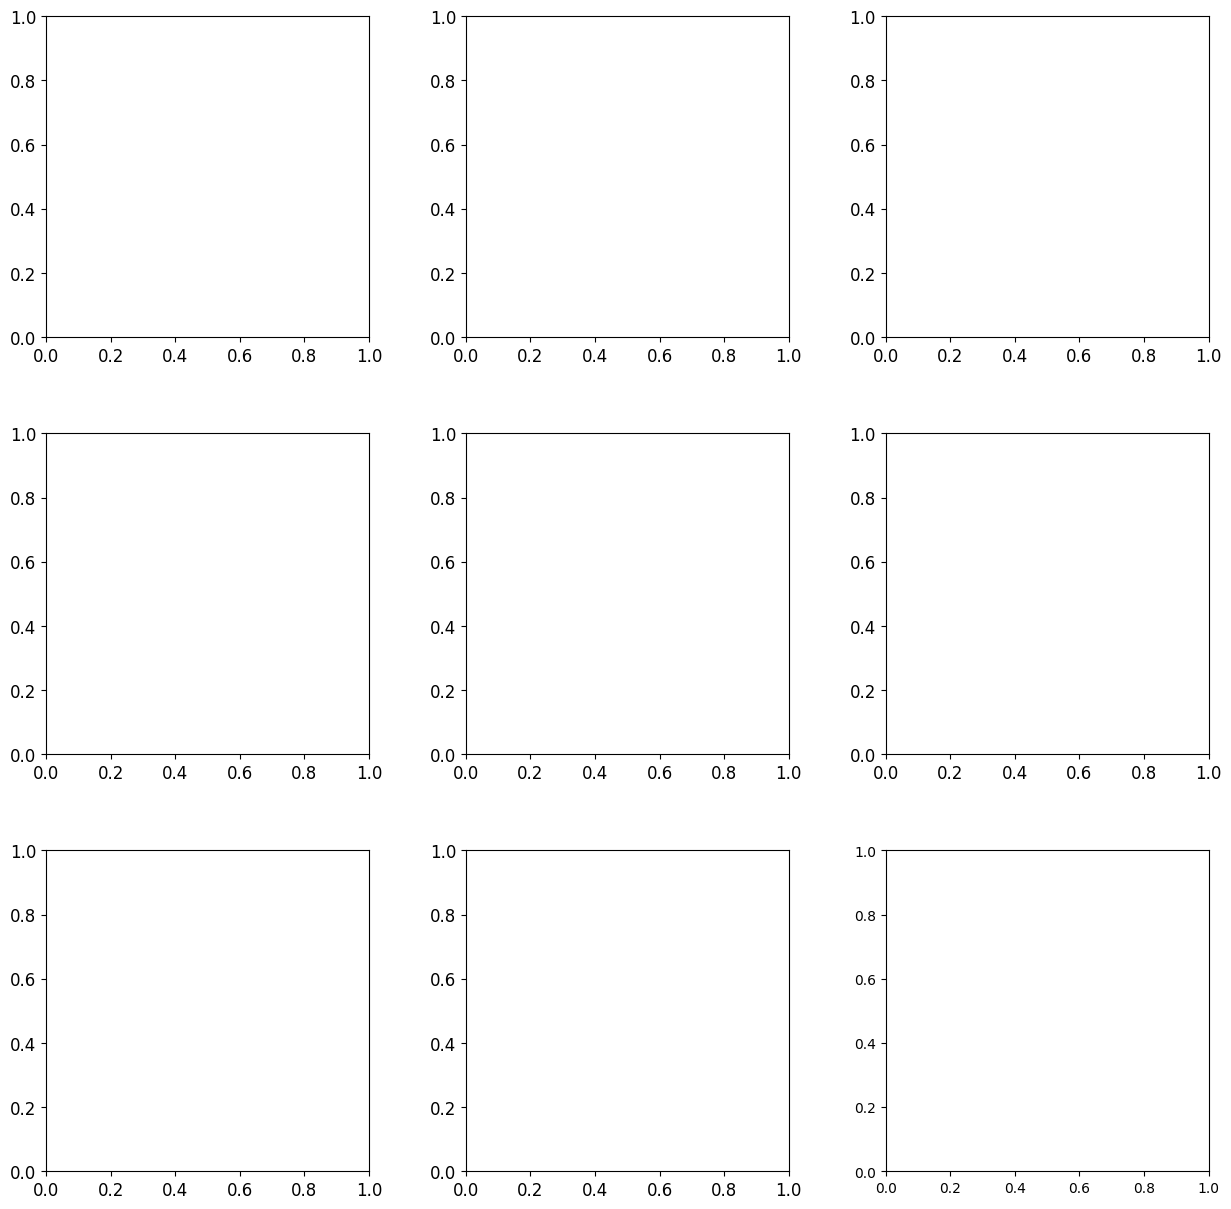

In [25]:
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

altimeter.reset()
velocity_estimator.reset()

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True
)
fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_altitude.mp4".format(dataset_name),fps=fps)